# Analisis Sentimen App MyPertamina
- **Nama:** NANTHA SEUTIA
- **Email:** ombakrinai@gmail.com

# Library

In [1]:
# 1. Install library yang dibutuhkan
!pip install google-play-scraper
!pip install Sastrawi

# 2. Import Library Utama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import re
import nltk
import string
import csv
import requests

# 3. Download NLTK resources BEFORE importing word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# 4. Import Google Play Scraper untuk mengambil ulasan aplikasi
from google_play_scraper import app, reviews, Sort, reviews_all

# 5. Import Sastrawi untuk Stemming dan Stopword Removal
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# 6. Import tambahan untuk pemrosesan teks dan visualisasi
from io import StringIO
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder

# 7. Library untuk TF-IDF dan BoW
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# 8. Model dan Evaluasi
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 9. Word2Vec untuk Representasi Teks
from gensim.models import Word2Vec

# 10. For Downloading file
from google.colab import files

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Pengumpulan Data

1. Web scraping menggunakan Google Play Scraper.
2. Dataset memiliki minimal 10.000 sampel.
3. Pemberian label kelas sentimen berdasarkan leksikon Bahasa Indonesia (positif, negatif, netral).


In [3]:
# 2. Data Gathering
# Scraping ulasan aplikasi MyPertamina
scrapreview = reviews_all(
    'com.dafturn.mypertamina',  # ID aplikasi
    lang='id',                  # Bahasa ulasan
    country='id',               # Negara
    sort=Sort.MOST_RELEVANT,    # Urutan ulasan
    count=15000                 # Maksimum jumlah ulasan yang diambil
)

# Konversi hasil scraping ke DataFrame
reviews_df = pd.DataFrame(scrapreview)

# Pastikan dataset memiliki minimal 10.000 sampel
if len(reviews_df) >= 10000:
    print("Dataset memenuhi syarat: >= 10.000 sampel.")
else:
    print("Dataset tidak memenuhi syarat.")

# Simpan dataset ke CSV
reviews_df.to_csv('mypertamina_reviews.csv', index=False, encoding='utf-8')

# Unduh file setelah disimpan
files.download('mypertamina_reviews.csv')

# Tampilkan datanya
reviews_df.head()

Dataset memenuhi syarat: >= 10.000 sampel.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,8eb604e7-6b35-4c77-9a01-7da325e46204,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi yang sangat buruk,isi data berlapis, ...",1,11,4.6.6,2025-02-10 23:53:44,"Hai, Sobat. Mimin sampaikan, mengambil foto ST...",2025-02-11 11:02:12,4.6.6
1,a4994116-a3c1-4a46-9001-1bfdfa10b9a2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Tadinya sdh bisa registrasi mypertamina dan sd...,1,93,4.6.6,2025-02-01 05:17:32,"Hai, Sobat Zen. Mohon maaf atas ketidaknyamana...",2025-02-01 08:25:03,4.6.6
2,46e5bca6-88fb-4b2a-98aa-03a815d8f7a9,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Makin kesini makin di persulit, mulai dari sud...",1,17,4.6.6,2025-02-08 21:37:29,"Hai, Sobat Julia. Mohon maaf atas ketidaknyama...",2025-02-09 08:37:36,4.6.6
3,b9f04c08-63ed-43d0-9fc1-83b51ccb3415,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Waktu percobaan sukses sampai buat barcode dan...,1,61,4.6.6,2025-01-26 14:15:22,"Hai, Sobat Suharmi. Mohon maaf atas ketidaknya...",2025-01-27 07:20:08,4.6.6
4,fca3bc80-b6fe-4ded-8b70-9d573a942d35,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,1. Sekarang ngga kaya dulu!!! Dulu bisa lewat ...,1,2,4.6.6,2025-02-12 03:31:07,"Hai, Sobat Sanu. Mimin sampaikan, mengambil fo...",2025-02-11 10:57:51,4.6.6


In [ ]:
# Tampilkan info data
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146628 entries, 0 to 146627
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              146628 non-null  object        
 1   userName              146628 non-null  object        
 2   userImage             146628 non-null  object        
 3   content               146628 non-null  object        
 4   score                 146628 non-null  int64         
 5   thumbsUpCount         146628 non-null  int64         
 6   reviewCreatedVersion  121845 non-null  object        
 7   at                    146628 non-null  datetime64[ns]
 8   replyContent          17681 non-null   object        
 9   repliedAt             17681 non-null   datetime64[ns]
 10  appVersion            121845 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 12.3+ MB


In [ ]:
# Hapus baris yang memiliki nilai yang hilang
clean_review_df = reviews_df.dropna()

# Hapus baris duplikat
clean_review_df = reviews_df.drop_duplicates()

# Tampilkan
clean_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146628 entries, 0 to 146627
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              146628 non-null  object        
 1   userName              146628 non-null  object        
 2   userImage             146628 non-null  object        
 3   content               146628 non-null  object        
 4   score                 146628 non-null  int64         
 5   thumbsUpCount         146628 non-null  int64         
 6   reviewCreatedVersion  121845 non-null  object        
 7   at                    146628 non-null  datetime64[ns]
 8   replyContent          17681 non-null   object        
 9   repliedAt             17681 non-null   datetime64[ns]
 10  appVersion            121845 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 12.3+ MB


# Preprocessing Data
1. Cleaning data
2. Case folding (lowercase)
3. Tokenization
4. Stopword Removal
5. Stemming

In [ ]:
# 3. Processing Data
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords_en = set(stopwords.words('english'))
    listStopwords.update(listStopwords_en)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [ ]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [ ]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_review_df['text_clean'] = clean_review_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_review_df['text_casefoldingText'] = clean_review_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_review_df['text_slangwords'] = clean_review_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_review_df['text_tokenizingText'] = clean_review_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_review_df['text_stopword'] = clean_review_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_review_df['text_akhir'] = clean_review_df['text_stopword'].apply(toSentence)

# Pelabelan Data

1. Gunakan leksikon data positif dan negatif untuk Bahasa Indonesia
2. Kolom sasaran adalah text_akhir



In [ ]:
# 4. Data Labelling
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [ ]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    words = text.split()  # Split the text into words!

    for word in words:
        if word in lexicon_positive:
            score = score + lexicon_positive[word]

    for word in words:
        if word in lexicon_negative:
            score = score + lexicon_negative[word]

    polarity = ''
    if score > 0:  # Corrected the condition here (no need for >= 0)
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'  # Explicitly set neutral

    return score, polarity

In [ ]:
results = clean_review_df['text_akhir'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_review_df['polarity_score'] = results[0]
clean_review_df['polarity'] = results[1]
print(clean_review_df['polarity'].value_counts())

polarity
negative    80178
neutral     33245
positive    33205
Name: count, dtype: int64


In [ ]:
label_encoder = LabelEncoder()

# Fit dan transform kolom 'polarity' menjadi numerik
clean_review_df['label'] = label_encoder.fit_transform(clean_review_df['polarity'])

# Tampilkan mapping label
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Tampilkan 5 baris teratas dengan label
clean_review_df[['polarity', 'label']].head()

{'negative': 0, 'neutral': 1, 'positive': 2}


,polarity,label
0,negative,0
1,negative,0
2,negative,0
3,negative,0
4,positive,2


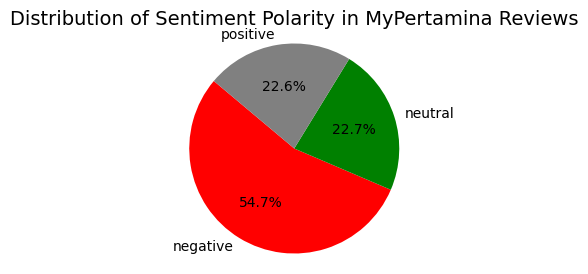

In [ ]:
# Calculate value counts of 'polarity' column
polarity_counts = clean_review_df['polarity'].value_counts()

# Create a DataFrame from the value counts (optional, but good practice)
df = pd.DataFrame({'polarity': polarity_counts.index, 'count': polarity_counts.values})

# Plotting the pie chart
plt.figure(figsize=(4, 3))  # Adjust figure size for better readability

# Define colors
colors = ['red', 'green', 'gray']

# Create the pie chart
plt.pie(df['count'], labels=df['polarity'], colors=colors,
        autopct='%1.1f%%', startangle=140)

# Add a title
plt.title('Distribution of Sentiment Polarity in MyPertamina Reviews', fontsize=14)

# Ensure the circle's proportion
plt.axis('equal')

# Show the plot
plt.show()

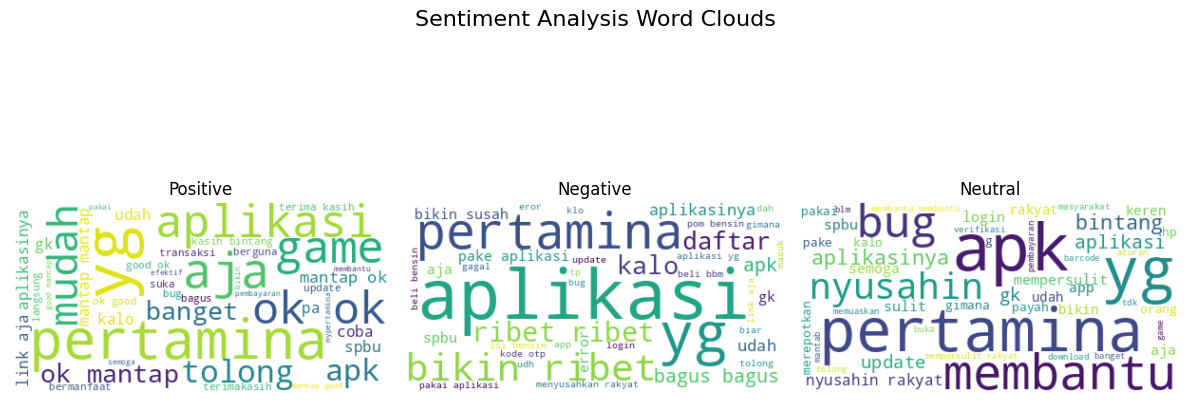

In [ ]:
# Function to generate word cloud (no display inside the function)
def generate_wordcloud(text):
    wordcloud = WordCloud(width=400, height=200,  # Smaller size
                          background_color='white',
                          max_words=100,  # Fewer words for clarity
                          min_font_size=8).generate(' '.join(text))
    return wordcloud


# Separate text by polarity
positive_text = clean_review_df[clean_review_df['polarity'] == 'positive']['text_akhir']
negative_text = clean_review_df[clean_review_df['polarity'] == 'negative']['text_akhir']
neutral_text = clean_review_df[clean_review_df['polarity'] == 'neutral']['text_akhir']

# Generate word clouds
positive_wc = generate_wordcloud(positive_text)
negative_wc = generate_wordcloud(negative_text)
neutral_wc = generate_wordcloud(neutral_text)

# Create a figure with subplots
fig = plt.figure(figsize=(12, 6))  # Adjust figure size

# Create a gridspec layout for better spacing
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  # 1 row, 3 columns

# Plotting the word clouds
ax1 = plt.subplot(gs[0])
ax1.imshow(positive_wc, interpolation='bilinear')
ax1.set_title('Positive', fontsize=12)
ax1.axis("off")

ax2 = plt.subplot(gs[1])
ax2.imshow(negative_wc, interpolation='bilinear')
ax2.set_title('Negative', fontsize=12)
ax2.axis("off")

ax3 = plt.subplot(gs[2])
ax3.imshow(neutral_wc, interpolation='bilinear')
ax3.set_title('Neutral', fontsize=12)
ax3.axis("off")

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.suptitle("Sentiment Analysis Word Clouds", fontsize=16)  # Overall title
plt.show()

# Pelatihan Machine Learning
1. Ekstraksi Fitur: Term Frequency-Inverse Document Frequency (TF-IDF)

Akurasi Model (Support Vector Machine): 0.9523289913387438

Laporan Klasifikasi (SVM):
               precision    recall  f1-score   support

           0       0.96      0.97      0.97     16108
           1       0.93      0.92      0.92      6712
           2       0.95      0.93      0.94      6506

    accuracy                           0.95     29326
   macro avg       0.95      0.94      0.94     29326
weighted avg       0.95      0.95      0.95     29326

Akurasi Model (RandomForestClassifier): 0.9156380004091932

Laporan Klasifikasi (Random Forest):
               precision    recall  f1-score   support

           0       0.90      0.97      0.93     16108
           1       0.95      0.90      0.92      6712
           2       0.93      0.79      0.86      6506

    accuracy                           0.92     29326
   macro avg       0.93      0.89      0.90     29326
weighted avg       0.92      0.92      0.91     29326



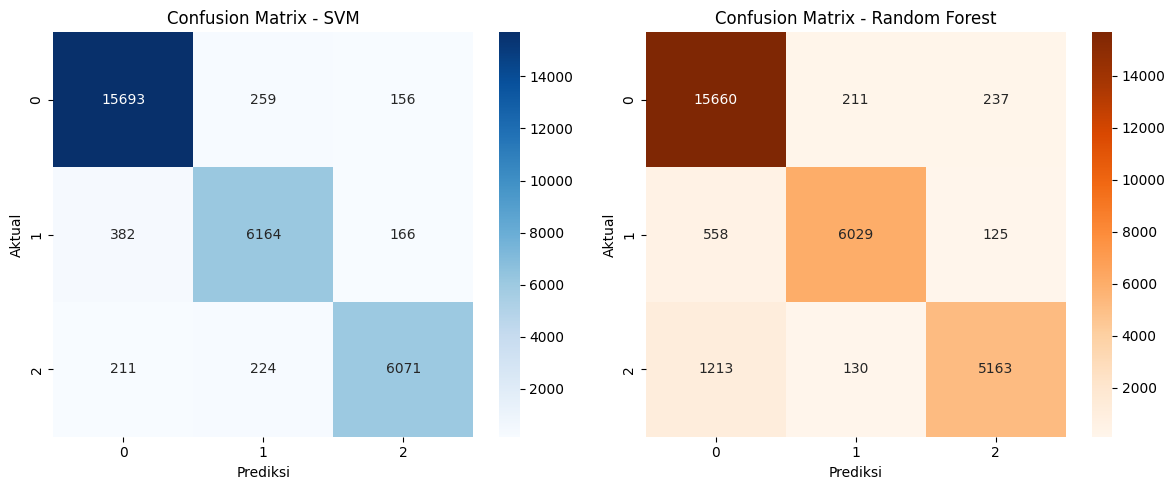

In [ ]:

# 1. Menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_review_df['text_akhir'])
y = clean_review_df['label']

# 2. Membagi Dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Model 1: Support Vector Machine
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# 4. Model 2: RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=110, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# 5. Evaluasi Model SVM
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Akurasi Model (Support Vector Machine):", accuracy_svm)
print("\nLaporan Klasifikasi (SVM):\n", classification_report(y_test, y_pred_svm))

# 6. Evaluasi Model RandomForest
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Akurasi Model (RandomForestClassifier):", accuracy_rf)
print("\nLaporan Klasifikasi (Random Forest):\n", classification_report(y_test, y_pred_rf))

# 7. Visualisasi Confusion Matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix - SVM")

plt.subplot(1, 2, 2)
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix - Random Forest")

plt.tight_layout()
plt.show()

Kesimpulan :
1. Akurasi Model
    * SVM mencapai akurasi 95.23%, lebih tinggi dibandingkan Random Forest yang memiliki akurasi 91.62%.
    * Perbedaan ini menunjukkan bahwa SVM lebih efektif dalam menangani dataset ini, kemungkinan karena sifatnya yang mencari hyperplane optimal dalam ruang vektor tinggi yang dihasilkan oleh TF-IDF.
2. Performa berdasarkan Precision, Recall, dan F1-Score
    * SVM menunjukkan performa yang lebih stabil di seluruh kelas dengan precision, recall, dan f1-score yang cukup seimbang.
    * Random Forest memiliki kelemahan dalam menangani kelas tertentu, terutama kelas 2 (label ketiga) yang memiliki recall lebih rendah (80% dibandingkan 93% pada SVM).
    * SVM lebih baik dalam menjaga keseimbangan antar kelas, sedangkan Random Forest lebih cenderung kuat dalam menangani kelas mayoritas (kelas 0 dan 1) tetapi mengalami penurunan performa pada kelas 2.
3. Analisis Confusion Matrix
    * Dari Confusion Matrix, terlihat bahwa SVM lebih sedikit melakukan kesalahan klasifikasi dibandingkan Random Forest.
    * Random Forest cenderung mengalami kesulitan dalam membedakan kelas minoritas, khususnya kelas 2.

2. Ekstraksi Fitur: Word2Vec

Akurasi Model (RandomForestClassifier): 0.8518720589238219

Laporan Klasifikasi (Random Forest):
               precision    recall  f1-score   support

           0       0.83      0.96      0.89     16108
           1       0.93      0.77      0.84      6712
           2       0.86      0.68      0.76      6506

    accuracy                           0.85     29326
   macro avg       0.87      0.80      0.83     29326
weighted avg       0.86      0.85      0.85     29326



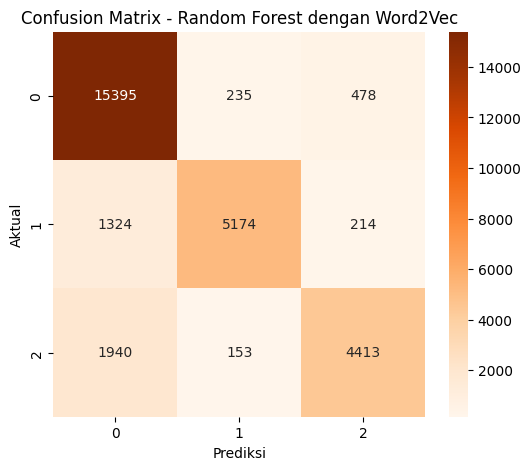

In [ ]:
# 1. Menggunakan Word2Vec untuk ekstraksi fitur
sentences = [text.split() for text in clean_review_df['text_akhir']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

def get_word2vec_features(text):
    words = text.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(word_vectors) == 0:
        return np.zeros(100)  # Sesuaikan dengan vector_size=100
    return np.mean(word_vectors, axis=0)

# Menggunakan list comprehension dengan dtype=object agar bentuk array tidak bermasalah
features_list = [get_word2vec_features(text) for text in clean_review_df['text_akhir']]

# Konversi ke numpy array dengan vstack untuk memastikan bentuk (n_samples, vector_size)
X = np.vstack(features_list)
y = clean_review_df['label']

# 2. Membagi Dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Model: RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# 4. Evaluasi Model RandomForest
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Akurasi Model (RandomForestClassifier):", accuracy_rf)
print("\nLaporan Klasifikasi (Random Forest):\n", classification_report(y_test, y_pred_rf))

# 5. Visualisasi Confusion Matrix
plt.figure(figsize=(6, 5))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix - Random Forest dengan Word2Vec")
plt.show()


# Summary

Setelah mengganti metode ekstraksi fitur dari TF-IDF ke Word2Vec, terlihat adanya perubahan signifikan pada performa model Random Forest Classifier (RFC).

1. Perbandingan Akurasi
    * Random Forest dengan Word2Vec memiliki akurasi 85.08%, yang lebih rendah dibandingkan TF-IDF (91.62%).
    * Penurunan ini menunjukkan bahwa Word2Vec tidak menangkap fitur yang cukup informatif untuk model Random Forest dalam tugas klasifikasi ini.
2. Analisis Precision, Recall, dan F1-Score
    * Kelas 0 (label mayoritas) masih memiliki performa terbaik (precision: 82%, recall: 96%), tetapi terjadi penurunan recall pada kelas minoritas (1 dan 2).
    * Kelas 1 mengalami penurunan recall dari 90% (TF-IDF) menjadi 77%, yang berarti banyak sampel dari kelas ini diklasifikasikan salah.
    * Kelas 2 mengalami penurunan recall dari 80% menjadi 68%, yang menunjukkan kesulitan model dalam mengenali pola di kelas ini.
3. Analisis Kesalahan dengan Confusion Matrix
    * Kesalahan klasifikasi meningkat, terutama pada kelas 1 dan 2.
    * Word2Vec yang menggunakan representasi berbasis rata-rata vektor kata mungkin kehilangan informasi penting, berbeda dengan TF-IDF yang tetap mempertahankan bobot berdasarkan kepentingan kata dalam dokumen.
4. Penyebab Potensial Penurunan Performa
    * Word2Vec bersifat lebih kontekstual, tetapi model Random Forest tidak memiliki mekanisme untuk memahami hubungan sekuensial antar kata.
    * Informasi frekuensi kata hilang karena Word2Vec hanya mengambil mean dari embedding kata, yang bisa menyebabkan informasi spesifik untuk kategori tertentu menjadi kabur.
    * Konteks sintaksis dan semantik mungkin tidak optimal karena Word2Vec lebih cocok untuk model berbasis deep learning seperti LSTM atau CNN dibandingkan model berbasis pohon keputusan seperti Random Forest.
5. Kesimpulan Akhir dan Rekomendasi
    * TF-IDF lebih unggul dibandingkan Word2Vec untuk model Random Forest, karena lebih efektif dalam merepresentasikan fitur teks dalam bentuk vektor numerik yang sesuai dengan pendekatan berbasis pohon keputusan.
    * Jika tetap ingin menggunakan Word2Vec, lebih baik mengganti model Random Forest dengan model deep learning seperti LSTM, CNN, atau Transformer-based models yang lebih cocok untuk menangkap hubungan antar kata dalam embedding.
    * Alternatif lain adalah mencoba pendekatan Hybrid TF-IDF + Word2Vec untuk melihat apakah kombinasi kedua teknik ini dapat meningkatkan performa model.

Penggunaan Word2Vec sebagai representasi fitur dalam Random Forest tidak lebih baik dibandingkan TF-IDF, dengan akurasi yang lebih rendah dan kesalahan klasifikasi yang lebih tinggi. Untuk klasifikasi berbasis Random Forest, TF-IDF tetap menjadi pilihan yang lebih efektif.